In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.graphics.gofplots as smgf
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plt.rcParams.update({'font.size': 14})

# Reziduuri

In [50]:
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# see also http://songhuiming.github.io/pages/2016/11/27/linear-regression-in-python-outliers-leverage-detect/
cars = pd.read_csv('mtcars.csv')
cars.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [3]:
mf = 'mpg ~ cyl + disp + hp + drat + wt + qsec + gear + carb'
model = smf.ols(formula=mf, data=cars).fit()

m_fitted_y = model.fittedvalues
m_resid = model.resid

# normalized residuals
m_norm_resid = model.get_influence().resid_studentized_internal
m_norm_resid_sqrt = np.sqrt(np.abs(m_norm_resid))
m_abs_resid = np.abs(m_resid)

m_leverage = model.get_influence().hat_matrix_diag
m_cooks = model.get_influence().cooks_distance[0]

In [4]:
print(OLSInfluence(model).dffits)

(0    -0.258042
1    -0.067827
2    -0.577871
3     0.034220
4     0.147440
5    -0.448855
6    -0.179290
7     0.161296
8    -1.447442
9    -0.090503
10   -0.478989
11    0.653128
12    0.320079
13   -0.085533
14   -0.355058
15   -0.001369
16    1.448193
17    0.882385
18    0.368837
19    1.072963
20   -1.062685
21   -0.360879
22   -0.513829
23   -0.262642
24    0.510759
25   -0.052784
26   -0.340848
27    0.830473
28   -2.823492
29   -0.030148
30    1.226085
31   -0.531366
dtype: float64, 1.0606601717798212)


In [5]:
print(OLSInfluence(model).dfbetas[:29, 8])

[-1.57323170e-01 -3.37986226e-02  3.31171700e-01  6.98409935e-03
  1.85242606e-02  6.62092645e-02 -7.19692122e-02  1.86172764e-02
 -2.12302391e-01 -3.00291627e-03 -6.50592391e-02 -3.78695670e-01
 -9.67719924e-02  2.34278924e-02 -1.46344425e-01 -9.40390373e-05
 -3.60019812e-01 -4.36923001e-01  1.60953644e-01  8.76714780e-03
 -1.32658684e-01  2.78191062e-02  8.70655057e-02  2.66120177e-02
  4.56249232e-02  1.28638239e-02  1.41701658e-01 -3.69623920e-02
  1.35821718e+00]


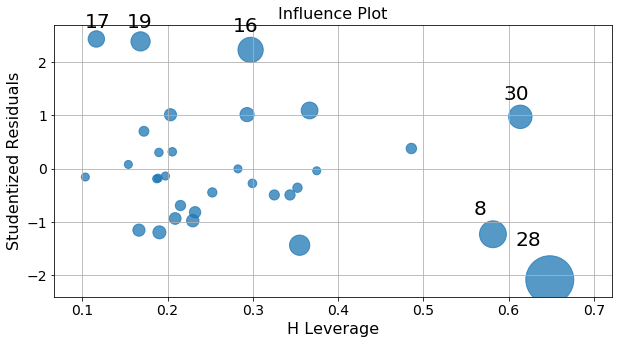

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid()
plt.show()

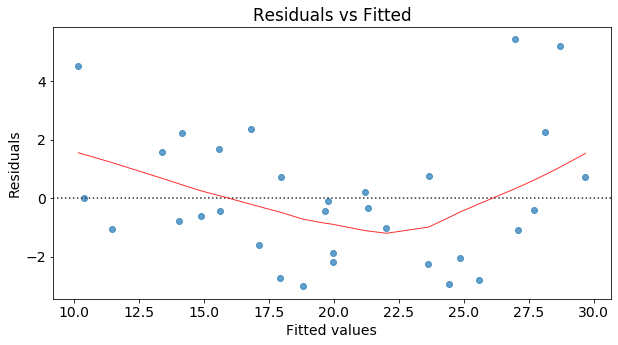

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.residplot(m_fitted_y, 'mpg', data=cars, lowess=True, scatter_kws={'alpha': 0.7},
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

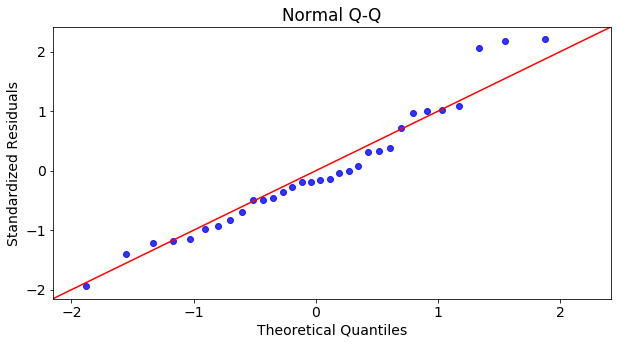

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
qq = smgf.ProbPlot(m_norm_resid)
qq.qqplot(line='45', alpha=0.8, lw=1, ax=ax)
ax.set_title('Normal Q-Q')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Standardized Residuals')
plt.show()

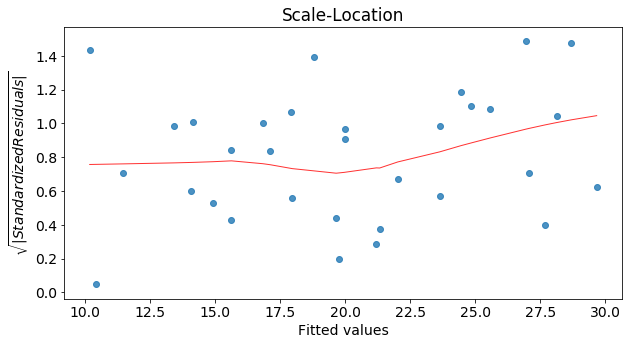

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_fitted_y, m_norm_resid_sqrt, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()

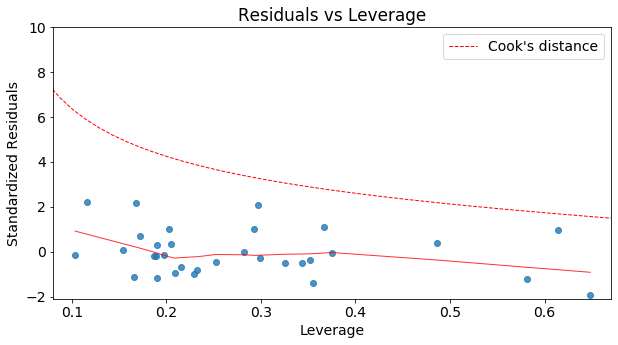

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_leverage, m_norm_resid, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')
ax.set_xlim(0.08, 0.67)
ax.set_ylim(-2.1, 10)

def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    ax.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.7, 50), 'Cook\'s distance') # 0.5 line
#graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
#      np.linspace(0.001, 0.7, 50)) # 1 line
ax.legend(loc='upper right');
plt.show()

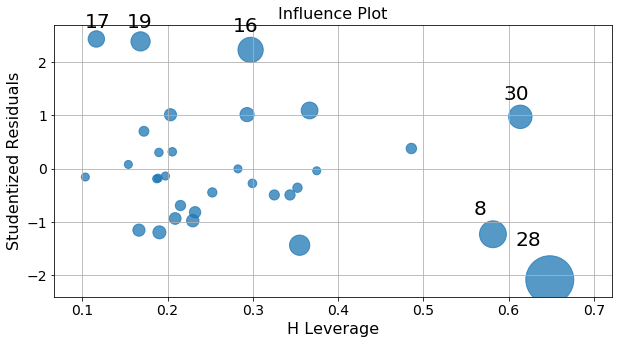

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

# Exemplu de leverage point

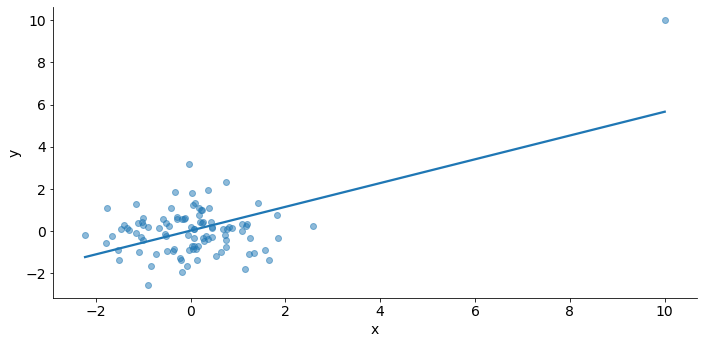

In [12]:
n = 100
x, y = np.r_[10, np.random.randn(n)], np.r_[10, np.random.randn(n)]
df = pd.DataFrame({'x': x, 'y': y})

sns.lmplot(x='x', y='y', data=df, aspect=2, ci=None,  # ci='95'
        scatter_kws={'lw': 1, 'alpha': 0.5})
plt.show()

In [13]:
model = smf.ols(formula='y ~ x', data=df).fit()
print(OLSInfluence(model).dfbetas[:10, 1])

[ 7.46673774e+00  3.10872529e-02  2.64278566e-03  8.13905812e-02
 -1.62391662e-01 -2.98580680e-03 -4.47698211e-02  5.86406102e-02
  2.17098191e-02  7.66682988e-03]


In [14]:
print(OLSInfluence(model).summary_frame().hat_diag.values[:10])

[0.5541233  0.01025331 0.00991834 0.01231474 0.02731239 0.01071524
 0.01104839 0.02380146 0.01099749 0.01000721]


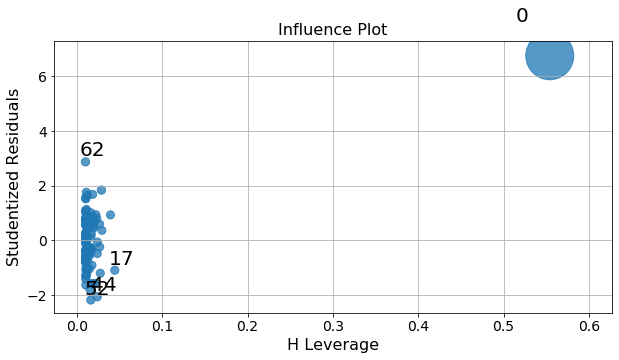

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

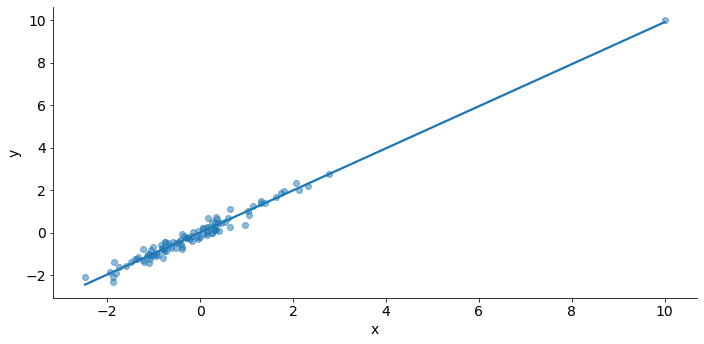

In [16]:
n = 100
x = np.r_[10, np.random.randn(n)] 
y = np.r_[10, x[1:] + .2 * np.random.randn(n)]
df = pd.DataFrame({'x': x, 'y': y})

sns.lmplot(x='x', y='y', data=df, aspect=2, ci=None, # ci='95'
           scatter_kws={'lw': 1, 'alpha': 0.5})
plt.show()

In [17]:
model = smf.ols(formula='y ~ x', data=df).fit()
print(OLSInfluence(model).dfbetas[:10, 1])

[ 0.56421398 -0.00292955  0.04216754 -0.04222316  0.01417392 -0.00236382
 -0.06388142  0.27426438 -0.03069793  0.02156872]


In [18]:
print(OLSInfluence(model).summary_frame().hat_diag.values[:10])

[0.50623928 0.01000873 0.01099773 0.0227036  0.01034253 0.01009482
 0.01727645 0.02512451 0.01079639 0.0111604 ]


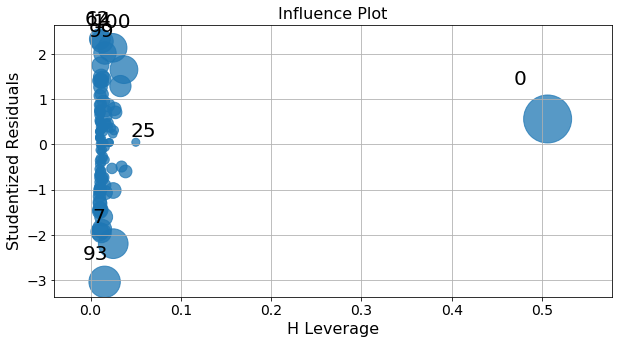

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sm.graphics.influence_plot(model, criterion='cooks', ax=ax)
plt.grid() ; plt.show()

In [20]:
st = pd.read_csv('stefanski.txt')
st = np.array([float(y) for x in st.values for y in x[0].split()]).reshape(-1, 5)
st = pd.DataFrame(st)
st.columns = ['v1', 'v2', 'v3', 'v4', 'v5']
st.head()

,v1,v2,v3,v4,v5
0,-0.75052,-0.282230,0.228190,-0.084136,-0.24748
1,-0.39380,-0.074787,-0.013689,0.072776,-0.36026
2,-0.15599,0.358390,-0.118070,0.013815,-0.65672
3,-0.68392,-0.059086,-0.060048,-0.231480,-0.03806
4,-0.59474,0.148360,-0.097664,0.667820,-1.05450


In [21]:
model = smf.ols(formula='v1 ~ v2 + v3 + v4 + v5 - 1', data=st).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     v1   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.050
Method:                 Least Squares   F-statistic:                              30.96
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                    3.85e-25
Time:                        09:07:55   Log-Likelihood:                         -3260.2
No. Observations:                2298   AIC:                                      6528.
Df Residuals:                    2294   BIC:                                      6551.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
v2             0.9856      0.128      7.701      0.000       0.735       1.237
v3             0.9715      0.127      7.671      0.000       0.723       1.220
v4             0.8606      0.120      7.197      0.000       0.626       1.095
v5             0.9267      0.083     11.127      0.000       0.763       1.090
==============================================================================
Omnibus:                     1417.819   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.591
Skew:                          -0.141   Prob(JB):                     1.33e-30
Kurtosis:                       1.835   Cond. No.                         4.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

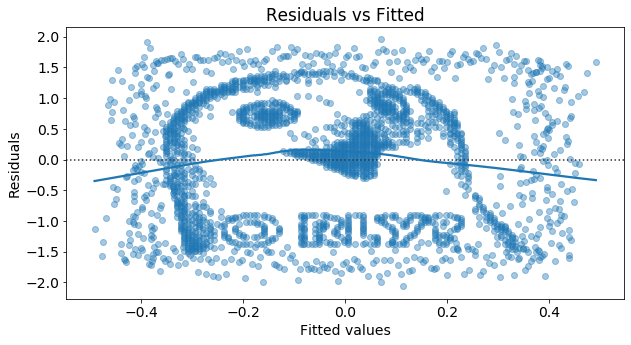

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.residplot(model.fittedvalues, 'v1', data=st, lowess=True, scatter_kws={'alpha': 0.4})
ax.set_title('Residuals vs Fitted') ; ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals') ; plt.show()

# Laborator

__Q1.__ Pentru datele de mai jos (cazul 1 de la curs):

a) reconstruiți graficul de la curs, figurînd mediile pentru ambele grupuri, și reconstruind dreptele de regresie (grupurile și dreptele colorate diferit, în funcție de grup);

b) observați diferența între medii precum și diferența dintre intercept-uri;

c) construiți valorile $y$ pentru a obține, succesiv, graficele din cazurile 2 - 5 de la curs, cu aceleași remarci de la punctul b).

Media grup1 :  0.4719600987562934
Media grup2 :  0.5316921938874841
Cazul 1: nu sunt corelate:


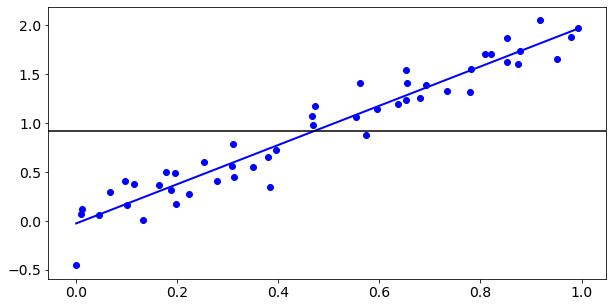

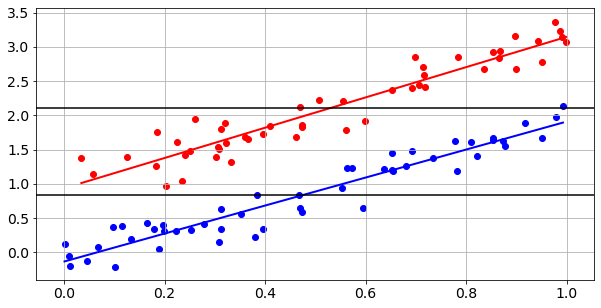

In [23]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n), + np.random.rand(n)]
t = np.array([0]*n + [1]*n)
y = beta0 + t + x * beta1 + np.random.randn(2*n)*sigma
lm1 = sm.OLS(y[:n], sm.add_constant(x[:n])).fit()
lm2 = sm.OLS(y[n:], sm.add_constant(x[n:])).fit()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[:n], y[:n], c='b')
ax.plot(np.sort(x[:n]), lm1.params[0] + lm1.params[1] * np.sort(x[:n]), 'b', lw=2)
ax.axhline(y=y[:n].mean(), c='k')

# fill in your code
x1 = x[:n]
x2 = x[n:]
t1 = t[:n]
t2 = t[n:]
print('Media grup1 : ', np.mean(x1))
print('Media grup2 : ', np.mean(x2))
y1 = beta0 + t1 + x1 * beta1 + np.random.randn(n)*sigma
y2 = beta0 + t2 + x2 * beta1 + np.random.randn(n)*sigma
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()
lm2 = sm.OLS(y2, sm.add_constant(x2)).fit()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x1, y1, c='b')
ax.plot(np.sort(x1), lm1.params[0] + lm1.params[1] * np.sort(x1), 'b', lw=2)
ax.axhline(y=y1.mean(), c='k')
ax.scatter(x2, y2, c='r')
ax.plot(np.sort(x2), lm2.params[0] + lm2.params[1] * np.sort(x2), 'r', lw=2)
ax.axhline(y=y2.mean(), c='k')

print('Cazul 1: nu sunt corelate:')
ax.grid() ; plt.show()

In [24]:
print('Medie grup1 : ', np.mean(y1))
print('Medie grup2 : ', np.mean(y2))

print('Intercept grup1 : ', lm1.params[0])
print('Intercept grup2 : ', lm2.params[0])

Medie grup1 :  0.8285723774250054
Medie grup2 :  2.1097097010856523
Intercept grup1 :  -0.13598695705274472
Intercept grup2 :  0.93435743374396


Media grup1 :  0.507092368045476
Media grup2 :  1.994840302176241
Cazul 2: Variabila x este puternic legata de grup


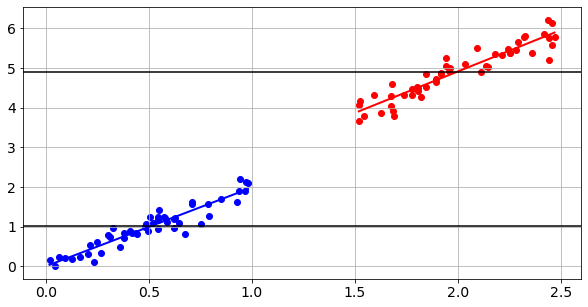

In [25]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n), + (np.random.rand(n)+1.5)]
t = np.array([0]*n + [1]*n)

# fill in your code
x1 = x[:n]
x2 = x[n:]
t1 = t[:n]
t2 = t[n:]
print('Media grup1 : ', np.mean(x1))
print('Media grup2 : ', np.mean(x2))
y1 = beta0 + t1 + x1 * beta1 + np.random.randn(n)*sigma
y2 = beta0 + t2 + x2 * beta1 + np.random.randn(n)*sigma
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()
lm2 = sm.OLS(y2, sm.add_constant(x2)).fit()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x1, y1, c='b')
ax.plot(np.sort(x1), lm1.params[0] + lm1.params[1] * np.sort(x1), 'b', lw=2)
ax.axhline(y=y1.mean(), c='k')
ax.scatter(x2, y2, c='r')
ax.plot(np.sort(x2), lm2.params[0] + lm2.params[1] * np.sort(x2), 'r', lw=2)
ax.axhline(y=y2.mean(), c='k')

print('Cazul 2: Variabila x este puternic legata de grup')
ax.grid() ; plt.show()

In [26]:
print('Medie grup1 : ', np.mean(y1))
print('Medie grup2 : ', np.mean(y2))

print('Intercept grup1 : ', lm1.params[0])
print('Intercept grup2 : ', lm2.params[0])

Medie grup1 :  1.0110584084434944
Medie grup2 :  4.905879907673547
Intercept grup1 :  0.0046846277130876135
Intercept grup2 :  0.7339822281806274


Media grup1 :  2.390764621820212
Media grup2 :  0.9741177928113973
Cazul 3: exista suprapunere intre grupuri


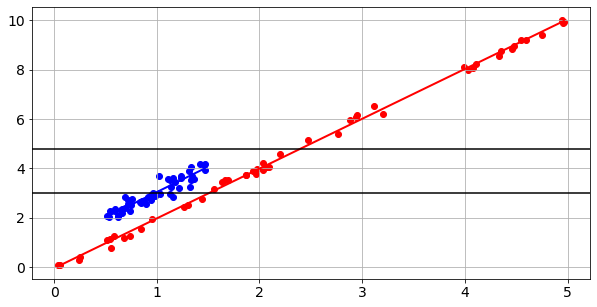

In [27]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n)*5, + (np.random.rand(n)+0.5)]
t = np.array([0]*n + [1]*n)

# fill in your code
x1 = x[:n]
x2 = x[n:]
t1 = t[:n]
t2 = t[n:]
print('Media grup1 : ', np.mean(x1))
print('Media grup2 : ', np.mean(x2))
y1 = beta0 + t1 + x1 * beta1 + np.random.randn(n)*sigma
y2 = beta0 + t2 + x2 * beta1 + np.random.randn(n)*sigma
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()
lm2 = sm.OLS(y2, sm.add_constant(x2)).fit()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x1, y1, c='r')
ax.plot(np.sort(x1), lm1.params[0] + lm1.params[1] * np.sort(x1), 'r', lw=2)
ax.axhline(y=y1.mean(), c='k')
ax.scatter(x2, y2, c='b')
ax.plot(np.sort(x2), lm2.params[0] + lm2.params[1] * np.sort(x2), 'b', lw=2)
ax.axhline(y=y2.mean(), c='k')

print('Cazul 3: exista suprapunere intre grupuri')
ax.grid() ; plt.show()

In [28]:
print('Medie grup1 : ', np.mean(y1))
print('Medie grup2 : ', np.mean(y2))

print('Intercept grup1 : ', lm1.params[0])
print('Intercept grup2 : ', lm2.params[0])

Medie grup1 :  4.778411943433837
Medie grup2 :  2.9863415818561094
Intercept grup1 :  -0.04448674345507414
Intercept grup2 :  0.9897387658355499


Media grup1 :  0.5202024144403076
Media grup2 :  0.04934827174368373
Cazul 4: fara diferenta intre medii


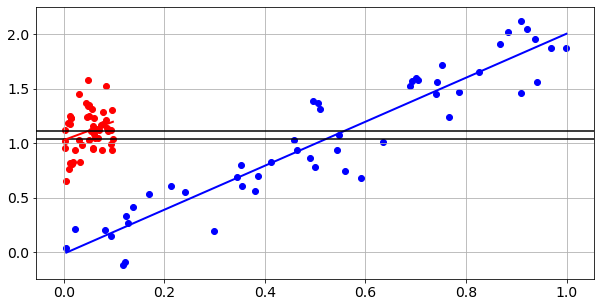

In [29]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n), + (np.random.rand(n)*0.1)]
t = np.array([0]*n + [1]*n)

# fill in your code
x1 = x[:n]
x2 = x[n:]
t1 = t[:n]
t2 = t[n:]
print('Media grup1 : ', np.mean(x1))
print('Media grup2 : ', np.mean(x2))
y1 = beta0 + t1 + x1 * beta1 + np.random.randn(n)*sigma
y2 = beta0 + t2 + x2 * beta1 + np.random.randn(n)*sigma
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()
lm2 = sm.OLS(y2, sm.add_constant(x2)).fit()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x1, y1, c='b')
ax.plot(np.sort(x1), lm1.params[0] + lm1.params[1] * np.sort(x1), 'b', lw=2)
ax.axhline(y=y1.mean(), c='k')
ax.scatter(x2, y2, c='r')
ax.plot(np.sort(x2), lm2.params[0] + lm2.params[1] * np.sort(x2), 'r', lw=2)
ax.axhline(y=y2.mean(), c='k')

print('Cazul 4: fara diferenta intre medii')
ax.grid() ; plt.show()

In [30]:
print('Medie grup1 : ', np.mean(y1))
print('Medie grup2 : ', np.mean(y2))

print('Intercept grup1 : ', lm1.params[0])
print('Intercept grup2 : ', lm2.params[0])

Medie grup1 :  1.034841170948697
Medie grup2 :  1.1123006632024544
Intercept grup1 :  -0.014031624230690952
Intercept grup2 :  1.0274281635734357


Media grup1 :  0.043951593919885
Media grup2 :  -0.06601213405206742


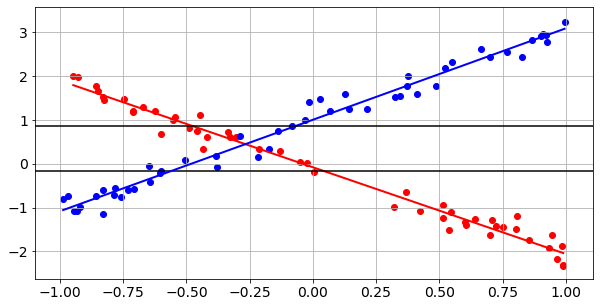

In [31]:
n, sigma = 50, .2
beta0, beta1 = 0, 2
x = np.r_[np.random.rand(n)*2-1, + (np.random.rand(n)*2-1)]
t = np.array([0]*n + [1]*n)

# fill in your code
x1 = x[:n]
x2 = x[n:]
t1 = t[:n]
t2 = t[n:]
print('Media grup1 : ', np.mean(x1))
print('Media grup2 : ', np.mean(x2))
y1 = beta0 + t1 + x1 * -beta1 + np.random.randn(n)*sigma
y2 = beta0 + t2 + x2 * beta1 + np.random.randn(n)*sigma
lm1 = sm.OLS(y1, sm.add_constant(x1)).fit()
lm2 = sm.OLS(y2, sm.add_constant(x2)).fit()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x1, y1, c='r')
ax.plot(np.sort(x1), lm1.params[0] + lm1.params[1] * np.sort(x1), 'r', lw=2)
ax.axhline(y=y1.mean(), c='k')
ax.scatter(x2, y2, c='b')
ax.plot(np.sort(x2), lm2.params[0] + lm2.params[1] * np.sort(x2), 'b', lw=2)
ax.axhline(y=y2.mean(), c='k')


ax.grid() ; plt.show()

In [32]:
print('Medie grup1 : ', np.mean(y1))
print('Medie grup2 : ', np.mean(y2))

print('Intercept grup1 : ', lm1.params[0])
print('Intercept grup2 : ', lm2.params[0])

Medie grup1 :  -0.1672579539405958
Medie grup2 :  0.8659740696813882
Intercept grup1 :  -0.08034917044414727
Intercept grup2 :  1.003667654575341


__Q2.__ Pentru datele sintetice generate mai jos:

a) realizați scatter plot-ul împreună cu dreapta de regresie Y($x_1$); există corelație între $Y$ și $x_1$?

b) figurați, precum la curs, culoarea punctului în funcție de $x_2$;

c) analizați acumdependența liniară dintre reziduurile lui $Y$ și $x_1$, anume dependența dintre $Y$ și $x_1$ în cazul în care din ambele variabile variabilitatea lui $x_2$ a fost deja eliminată. Ce observați?

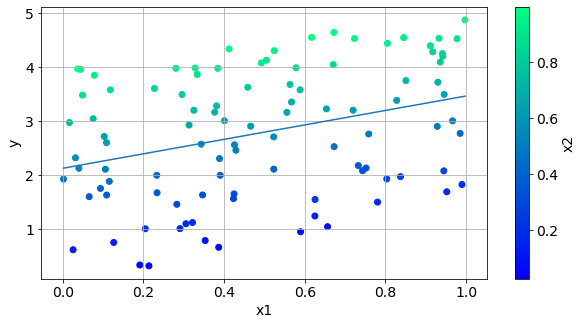

In [33]:
p, n = 1, 100
x2 = np.random.rand(n)
x1 = p * np.random.rand(n) - (1-p) * x2
beta0, beta1, tau, sigma = 0, 1, 4, .01
y = beta0 + x1 * beta1 + tau * x2 + np.random.randn(n)*sigma
df = pd.DataFrame({'x1': x1, 'y': y})
params = smf.ols(formula='y ~ x1', data=df).fit().params

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cm = plt.cm.get_cmap('winter')
sc = ax.scatter(x1, y, c=x2, cmap=cm)
x = np.linspace(min(x1), max(x1), 10)
ax.plot(x, params[0] + x * params[1])
ax.set_xlabel('x1') ; ax.set_ylabel('y')
fig.colorbar(sc, ax=ax).set_label('x2')
ax.grid() ; plt.show()

In [34]:
print('Corelatie intre y si x1: ', np.corrcoef(y,x1)[0,1])

Corelatie intre y si x1:  0.3409164876532674


In [35]:
df['x2'] = x2
smf1 = smf.ols(formula='y ~ x2', data=df).fit()
smf2 = smf.ols(formula='x1 ~ x2', data=df).fit()

df['residY'] = smf1.resid
df['residX1'] = smf2.resid

smf_ = smf.ols(formula='residY ~ residX1 - 1', data=df).fit()
_smf = smf.ols(formula='y ~ x1 + x2', data=df).fit()
_smf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.529e+05
Date:                Thu, 18 Jun 2020   Prob (F-statistic):          5.46e-201
Time:                        09:08:01   Log-Likelihood:                 316.27
No. Observations:                 100   AIC:                            -626.5
Df Residuals:                      97   BIC:                            -618.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0024      0.003     -0.871      0.386      -0.008       0.003
x1             1.0005      0.003    289.139      0.000       0.994       1.007
x2             4.0054      0.004   1074.255      0.000       3.998       4.013
==============================================================================
Omnibus:                        4.347   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.673
Skew:                          -0.398   Prob(JB):                        0.159
Kurtosis:                       3.499   Cond. No.                         5.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
smf_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 residY   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          8.533e+04
Date:                Thu, 18 Jun 2020   Prob (F-statistic):                   3.75e-147
Time:                        09:08:01   Log-Likelihood:                          316.27
No. Observations:                 100   AIC:                                     -630.5
Df Residuals:                      99   BIC:                                     -627.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
residX1        1.0005      0.003    292.105      0.000       0.994       1.007
==============================================================================
Omnibus:                        4.347   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.673
Skew:                          -0.398   Prob(JB):                        0.159
Kurtosis:                       3.499   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
print('X2 nu este relevant : coeficientul lui x1 = coeficientul lui residX1')

X2 nu este relevant : coeficientul lui x1 = coeficientul lui residX1


__Q3.__ Pentru setul seatbelts, potriviți un model liniar pentru răspunsul deaths în funcție de predictorii kms și PetrolPrice. Interpretați rezultatele.

In [38]:
seatbelts = pd.read_csv('seatbelts.csv')
seatbelts.head()

,Unnamed: 0,DriversKilled,drivers,front,rear,kms,PetrolPrice,VanKilled,law
0,1,107,1687,867,269,9059,0.102972,12,0
1,2,97,1508,825,265,7685,0.102363,6,0
2,3,102,1507,806,319,9963,0.102062,12,0
3,4,87,1385,814,407,10955,0.100873,8,0
4,5,119,1632,991,454,11823,0.101020,10,0


In [39]:
lm = smf.ols(formula='DriversKilled ~ kms + PetrolPrice', 
             data=seatbelts).fit()
print(lm.params)
lm.summary()

Intercept      215.746125
kms             -0.001750
PetrolPrice   -643.789460
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          DriversKilled   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     21.37
Date:                Thu, 18 Jun 2020   Prob (F-statistic):           4.29e-09
Time:                        09:08:01   Log-Likelihood:                -873.28
No. Observations:                 192   AIC:                             1753.
Df Residuals:                     189   BIC:                             1762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     215.7461     14.666     14.711      0.000     186.817     244.675
kms            -0.0017      0.001     -2.847      0.005      -0.003      -0.001
PetrolPrice  -643.7895    148.290     -4.341      0.000    -936.305    -351.274
==============================================================================
Omnibus:                        6.488   Durbin-Watson:                   0.907
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                6.155
Skew:                           0.384   Prob(JB):                       0.0461
Kurtosis:                       2.577   Cond. No.                     1.37e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
print('Si kms si PetrolPrice sunt relevante deoarece au Pval<=0.005')

Si kms si PetrolPrice sunt relevante deoarece au Pval<=0.005


__Q4.__ Pentru același set seatbelts, comparați coeficientul (panta) pentru kms cu și fără includerea PetrolPrice în model.

In [41]:
smf.ols(formula='DriversKilled ~ kms + PetrolPrice', 
             data=seatbelts).fit().params

Intercept      215.746125
kms             -0.001750
PetrolPrice   -643.789460
dtype: float64

In [42]:
smf.ols(formula='DriversKilled ~ kms', 
             data=seatbelts).fit().params

Intercept    164.391144
kms           -0.002774
dtype: float64

__Q5.__ Realizați același lucru pentru PetrolPrice, acum incluzînd (sau nu) kms în model.

In [43]:
smf.ols(formula='DriversKilled ~ PetrolPrice', 
             data=seatbelts).fit().params

Intercept      206.308529
PetrolPrice   -805.860052
dtype: float64

__Q6.__ Realizați analiza reziduurilor folosind dfbetas și hat values. Căutați minime sau maxime. Extrema este la distanță de un ordin de mărime?

In [44]:
mf = 'DriversKilled ~ drivers + front + rear + kms + PetrolPrice + VanKilled + law'
model = smf.ols(formula=mf, data=seatbelts).fit()
dfbetas=OLSInfluence(model).dfbetas
#cat de mult se schimba panta daca acel punct este inclus, coef x pct 
hatval=OLSInfluence(model).summary_frame().hat_diag.values
#masoara leverage, cat de mult este deplasat fata de medie punctul pe x
print(dfbetas)
print(hatval)

[[ 0.0075259   0.11918958 -0.15462421 ... -0.0784234  -0.02887209
  -0.12529484]
 [-0.0592902   0.0795542  -0.06207241 ... -0.03555944  0.08546701
  -0.04509099]
 [-0.02525265  0.03112842 -0.00843729 ... -0.0049578  -0.00980128
  -0.00787416]
 ...
 [ 0.01581392 -0.0074105  -0.00788942 ... -0.00370545 -0.00807934
  -0.02731149]
 [-0.00625083  0.03017104 -0.01797054 ...  0.00309969 -0.01885661
   0.0215044 ]
 [-0.06459568  0.19806044 -0.12309437 ...  0.02543366 -0.02097352
   0.1675726 ]]
[0.0528204  0.08707999 0.03502931 0.06227887 0.03465648 0.038815
 0.04662423 0.06599903 0.03533055 0.05902897 0.04273503 0.04612283
 0.04704007 0.0591716  0.06687643 0.03143241 0.04547969 0.02987884
 0.03488592 0.07240714 0.02526935 0.0384972  0.04791329 0.09125397
 0.03904445 0.07276613 0.02763015 0.02678243 0.01687221 0.02589202
 0.03154507 0.08418517 0.02495042 0.02264386 0.0327776  0.03346009
 0.03245718 0.06486401 0.02840514 0.03078775 0.03071045 0.04003181
 0.04739593 0.05268585 0.0159803  0.04344

In [45]:
print('min hatval:',min(hatval))
print('max hatval:',max(hatval))
print('min dfbeta:',np.amin(dfbetas))
print('max dfbeta:',np.amax(dfbetas))

min hatval: 0.012358289118613253
max hatval: 0.10050004408530548
min dfbeta: -0.31744459666537667
max dfbeta: 0.40740399689519424


__Q7.__ Ridicați diagramele Residuals vs. Fitted, Q-Q plot, Scale-Location, Residuals vs. Leverage (aceasta din urmă ridicați-o folosind Studentized Residuals vs. H Leverage). Încercați să explicați ce observați.

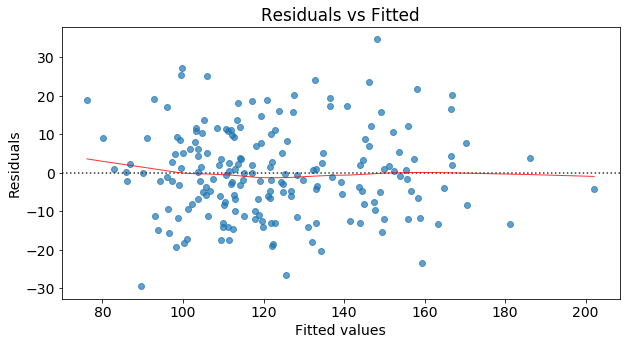

In [46]:
#Residuals vs. Fitted
m_fitted_y = model.fittedvalues
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.residplot(m_fitted_y, 'DriversKilled', data=seatbelts, lowess=True, scatter_kws={'alpha': 0.7},
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()
#uniform imprastiate

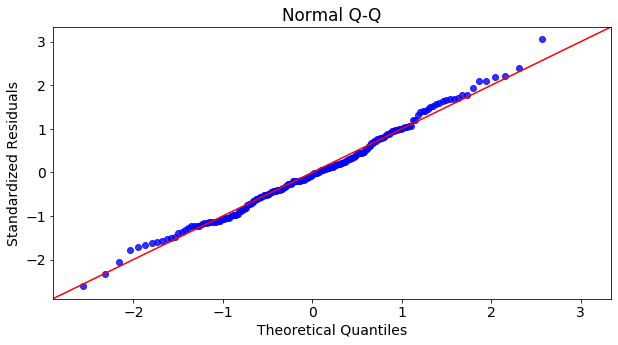

In [47]:
#Q-Q plot
m_norm_resid = model.get_influence().resid_studentized_internal
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
qq = smgf.ProbPlot(m_norm_resid)
qq.qqplot(line='45', alpha=0.8, lw=1, ax=ax)
ax.set_title('Normal Q-Q')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Standardized Residuals')
plt.show()
#distribuite normal

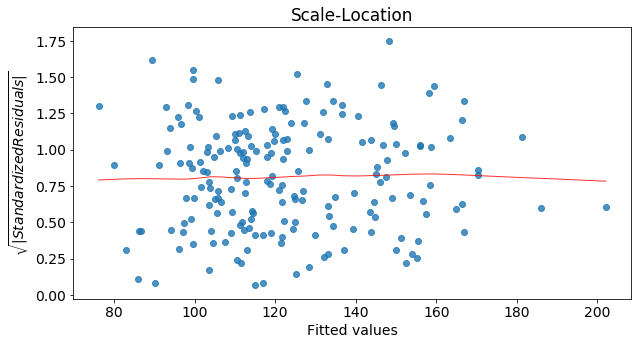

In [48]:
# Scale-Location
m_norm_resid_sqrt = np.sqrt(np.abs(m_norm_resid))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_fitted_y, m_norm_resid_sqrt, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Scale-Location')
ax.set_xlabel('Fitted values')
ax.set_ylabel('$\sqrt{|Standardized Residuals|}$')
plt.show()
#distributie egala

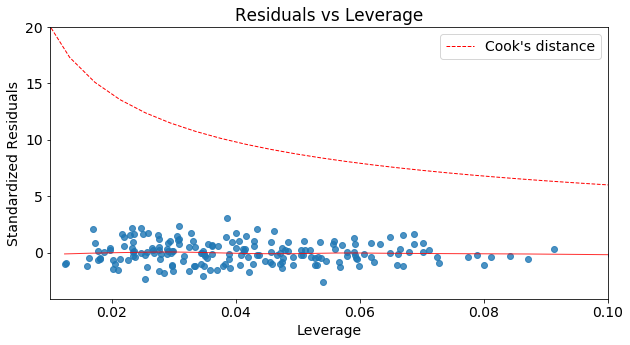

In [49]:
# Residuals vs. Leverage - Studentized Residuals vs. H Leverage
m_leverage = model.get_influence().hat_matrix_diag
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.regplot(m_leverage, m_norm_resid, scatter=True, lowess=True,
           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
ax.set_title('Residuals vs Leverage')
ax.set_xlabel('Leverage')
ax.set_ylabel('Standardized Residuals')
ax.set_xlim(0.01, 0.1)
ax.set_ylim(-4.1, 20)

def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    ax.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model.params) # number of model parameters
graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.2, 50), 'Cook\'s distance') # 0.5 line
#graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
#      np.linspace(0.001, 0.7, 50)) # 1 line
ax.legend(loc='upper right');
plt.show()